<a href="https://colab.research.google.com/github/aashrithresearch/endometrial-cancer/blob/main/models/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q datasets transformers accelerate

In [3]:
from datasets import load_dataset

dataset = load_dataset('/content/drive/MyDrive/histopathological image dataset for ET (2)')

Resolving data files:   0%|          | 0/3311 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [4]:
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

In [5]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 2979
})

In [6]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['Endometrial Adenocarcinoma', 'Endometrial Hyperplasia', 'Endometrial Polyp', 'Normal Endometrium'], id=None)}

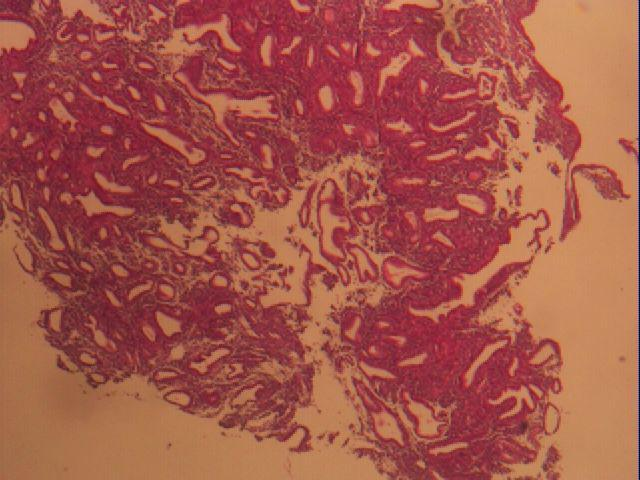

In [7]:
train_ds[0]['image']

In [8]:
train_ds[0]['label']

2

In [9]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'Endometrial Adenocarcinoma',
 1: 'Endometrial Hyperplasia',
 2: 'Endometrial Polyp',
 3: 'Normal Endometrium'}

In [10]:
id2label[train_ds[0]['label']]

'Endometrial Polyp'

In [11]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [12]:
from torchvision.transforms import (CenterCrop,
                                    Compose,
                                    Normalize,
                                    RandomHorizontalFlip,
                                    RandomResizedCrop,
                                    Resize,
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

In [13]:
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)

In [14]:
train_ds[:2]

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>,
  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480>],
 'label': [2, 3],
 'pixel_values': [tensor([[[ 0.5922,  0.5922,  0.5922,  ...,  0.4510,  0.5294,  0.5216],
           [ 0.5922,  0.5922,  0.5922,  ...,  0.5294,  0.5451,  0.5294],
           [ 0.5922,  0.5922,  0.5922,  ...,  0.5373,  0.5294,  0.5294],
           ...,
           [ 0.5529,  0.5529,  0.5451,  ...,  0.4039,  0.4353,  0.3961],
           [ 0.5451,  0.5451,  0.5373,  ...,  0.4980,  0.5059,  0.4431],
           [ 0.5451,  0.5451,  0.5373,  ...,  0.5059,  0.4980,  0.4588]],
  
          [[ 0.0980,  0.0980,  0.0980,  ..., -0.2235, -0.1216, -0.1216],
           [ 0.0980,  0.0980,  0.0980,  ..., -0.1137, -0.0745, -0.0902],
           [ 0.0980,  0.0980,  0.0980,  ..., -0.0588, -0.0745, -0.0745],
           ...,
           [ 0.0902,  0.0902,  0.0824,  ..., -0.0902, -0.0667, -0.1059],
           [ 0.0824,  0.0824,  0.0745,  ...,  0.0039,  0

In [15]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [16]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [17]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-et",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=15,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels), precision_recall_fscore_support=precision_recall_fscore_support(predictions, labels, average='macro'))

In [20]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [22]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.580021,0.819277
2,0.291300,0.507640,0.831325
3,0.291300,0.488130,0.834337
4,0.257100,0.435002,0.867470
5,0.257100,0.565315,0.840361
6,0.242400,0.529133,0.849398
7,0.193900,0.430631,0.873494
8,0.193900,0.558921,0.843373
9,0.155800,0.517487,0.861446
10,0.155800,0.608444,0.852410


TrainOutput(global_step=4470, training_loss=0.17333739107887217, metrics={'train_runtime': 2375.6876, 'train_samples_per_second': 18.809, 'train_steps_per_second': 1.882, 'total_flos': 3.4627916266275226e+18, 'train_loss': 0.17333739107887217, 'epoch': 15.0})

In [24]:
trainer.evaluate()

{'eval_loss': 0.4306308329105377,
 'eval_accuracy': 0.8734939759036144,
 'eval_runtime': 10.8541,
 'eval_samples_per_second': 30.588,
 'eval_steps_per_second': 7.647,
 'epoch': 15.0}